### ALS Experiments

In [1]:
"""
Keeping the same structure as SimpleCuboidMesh script
 - The older one wasn't working well with ALS data
 - Since we had very less points for vertical components (Since computing principal axis is a major step, the alignment wont work well due to the dominant
   nature of the roof data - orientation will get greatly affected by roof shape)
 - So the objective is to construct axis aligned oriented cuboid
"""

"\nKeeping the same structure as SimpleCuboidMesh script\n - The older one wasn't working well with ALS data\n - Since we had very less points for vertical components (Since computing principal axis is a major step, the alignment wont work well due to the dominant\n   nature of the roof data - orientation will get greatly affected by roof shape)\n - So the objective is to construct axis aligned oriented cuboid\n"

### **Downsampling ground**
- Goal is to downsample the ground data -> Used to ground the reconstructed cuboids
- Accept the ground data, and downsample the data
- This processed data will be the input for PCA to reduce the load

In [2]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
"""
DIDN'T USE THIS METHOD, INSTEAD USED MESHLAB'S POINT SIMPLIFICATION FOR PROCESSING
"""

ptCloud = o3d.io.read_point_cloud("/mnt/d/Krishna/Research/DigitalTwins/LOD1 Work/ParisLille/Separated/Ground_2.ply")
print(ptCloud)

PointCloud with 16425215 points.


In [ ]:
noNeighbours = 10  #No of neighbours
sdRatio = 1.5 #Std deviation ratio

#Statistical filtering
inlierCloud, outlierCloud = ptCloud.remove_statistical_outlier(
    nb_neighbors=noNeighbours, std_ratio=sdRatio
)

In [5]:
FPtDSampledCloud = inlierCloud.farthest_point_down_sample(num_samples=1000000)

In [6]:
o3d.io.write_point_cloud("InputOutput/Lille2GroundDownsampled.ply", FPtDSampledCloud)

True

### **1. Contructing axis aligned (Ground aware) oriented cuboid (LOD1)**

**Concept :**
- Instead of going with typical axis alignment, will be going with a ground aware approach
- Will be using downsampled ground (Uses MeshLab's Point Cloud simplification)

**Methodology :**
- Downsampled ground data, and the buildilngs or the entities are taken as the input
- Based on the centroid of the building, will be performing a radius search on the ground points, and these neighbouring points are taken into consideration
- Median Z value of these local ground points is used as the ground elevation reference for that building
- Z coordinates of the building points are normalized by subtracting the local ground height, ensuring that the cuboid will be constructed relative to the local ground surface
- PCA on XY plane is performed (2D) to determine the primary orientation of the structure in the horizontal plane
- Local rotation matrix is computed to align the structure’s footprint with the XY axes
- Bounding box is computed in the rotated space

In [ ]:
#------------------------------------------------------------------------------------------<Imports>----------------------||
import pyvista as pv
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#------------------------------------------------------------------------------------------<Load PLY>---------------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    return np.array(cloud.points), cloud

In [ ]:
#------------------------------------------------------------------------------------------<Ground aware OBB>-------------||
def groundAlignedBoundingBox(buildingPoints, groundPoints, radius=10.0):
    buildingCenter = np.mean(buildingPoints, axis=0)
    dists = np.linalg.norm(groundPoints[:, :2] - buildingCenter[:2], axis=1)
    localGround = groundPoints[dists < radius]
    
    if len(localGround) < 10:
        raise ValueError("Not enough grnd pts")
    #--------------------------------------------------------------------------------------<Get ground Z and subtract>----||
    groundZ = np.median(localGround[:, 2])
    buildingPoints[:, 2] -= groundZ #Get ground Z and subtract

    #--------------------------------------------------------------------------------------<2D PCA for XY rotation>-------||
    xyPoints = buildingPoints[:, :2]
    meanXY = np.mean(xyPoints, axis=0)
    centeredXY = xyPoints - meanXY
    covXY = np.cov(centeredXY, rowvar=False)
    eigVals, eigVecs = np.linalg.eigh(covXY)
    order = np.argsort(-eigVals)
    eigVecs = eigVecs[:, order]

    rotXY = eigVecs
    rotMat3D = np.eye(3)
    rotMat3D[:2, :2] = rotXY

    rotatedPoints = (buildingPoints - [meanXY[0], meanXY[1], 0]) @ rotMat3D

    #--------------------------------------------------------------------------------------<Construct OBB>----------------||
    minPt = np.min(rotatedPoints, axis=0)
    maxPt = np.max(rotatedPoints, axis=0)

    base = np.array([
        [minPt[0], minPt[1], minPt[2]],
        [maxPt[0], minPt[1], minPt[2]],
        [maxPt[0], maxPt[1], minPt[2]],
        [minPt[0], maxPt[1], minPt[2]]
    ])
    top = base.copy()
    top[:, 2] = maxPt[2]

    vertices = np.vstack([base, top])
    vertices = (vertices @ rotMat3D.T) + [meanXY[0], meanXY[1], groundZ]

    faces = np.array([
        [4, 0, 1, 2, 3],
        [4, 4, 5, 6, 7],
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    return pv.PolyData(vertices, faces)

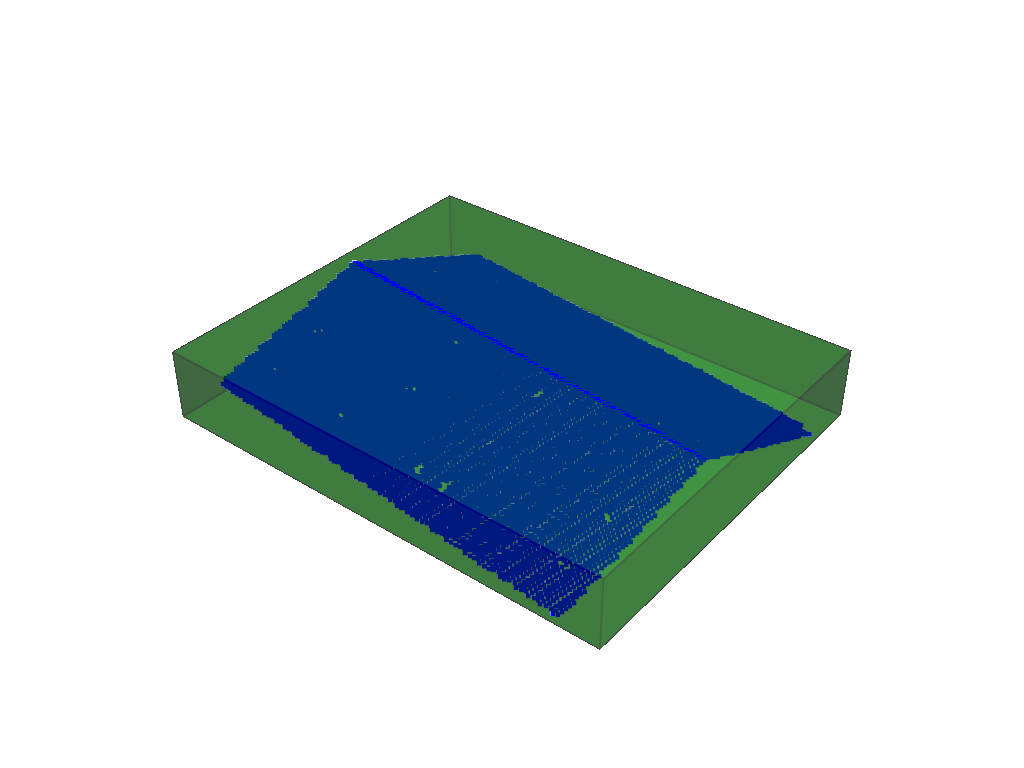

In [ ]:
buildingFile = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments/28AN1_16/Separated/Bldngs__000008.ply"
groundFile = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments/28AN1_16/28AN1_16_Ground.ply"

buildingPoints, buildingMesh = loadPC(buildingFile)
groundPoints, _ = loadPC(groundFile)

cuboid = groundAlignedBoundingBox(buildingPoints.copy(), groundPoints)

#------------------------------------------------------------------------------------------<Visualize>-------------------||
plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(buildingPoints + [0, 0, 0]), color="blue", point_size=5)
plotter.add_mesh(cuboid, color="green", opacity=0.5, show_edges=True, edge_color="black", line_width=2)
plotter.show()

In [ ]:
cuboid.save("Outputs/28AN1_16_Bldngs__000008.ply")

#### 1.1 Iteratively building cuboids

In [ ]:
#------------------------------------------------------------------------------------------<Imports>---------------------||
import pyvista as pv
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

In [22]:
#------------------------------------------------------------------------------------------<Load PLY Files>---------------||
def loadPC(plyFile):
    cloud = pv.read(plyFile)
    return np.array(cloud.points)

In [ ]:
#------------------------------------------------------------------------------------------<Ground aware OBB>-------------||
def groundAlignedBoundingBox(buildingPoints, groundPoints, radius=10.0):
    buildingCenter = np.mean(buildingPoints, axis=0)
    dists = np.linalg.norm(groundPoints[:, :2] - buildingCenter[:2], axis=1)
    localGround = groundPoints[dists < radius]
    
    if len(localGround) < 10:
        raise ValueError("Not enough grnd pts")
    #--------------------------------------------------------------------------------------<Get ground Z and subtract>----||
    groundZ = np.median(localGround[:, 2])
    buildingPoints[:, 2] -= groundZ #Get ground Z and subtract

    #--------------------------------------------------------------------------------------<2D PCA for XY rotation>-------||
    xyPoints = buildingPoints[:, :2]
    meanXY = np.mean(xyPoints, axis=0)
    centeredXY = xyPoints - meanXY
    covXY = np.cov(centeredXY, rowvar=False)
    eigVals, eigVecs = np.linalg.eigh(covXY)
    order = np.argsort(-eigVals)
    eigVecs = eigVecs[:, order]

    rotXY = eigVecs
    rotMat3D = np.eye(3)
    rotMat3D[:2, :2] = rotXY

    rotatedPoints = (buildingPoints - [meanXY[0], meanXY[1], 0]) @ rotMat3D

    #--------------------------------------------------------------------------------------<Construct OBB>----------------||
    minPt = np.min(rotatedPoints, axis=0)
    maxPt = np.max(rotatedPoints, axis=0)

    base = np.array([
        [minPt[0], minPt[1], minPt[2]],
        [maxPt[0], minPt[1], minPt[2]],
        [maxPt[0], maxPt[1], minPt[2]],
        [minPt[0], maxPt[1], minPt[2]]
    ])
    top = base.copy()
    top[:, 2] = maxPt[2]

    vertices = np.vstack([base, top])
    vertices = (vertices @ rotMat3D.T) + [meanXY[0], meanXY[1], groundZ]

    faces = np.array([
        [4, 0, 1, 2, 3],
        [4, 4, 5, 6, 7],
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    return pv.PolyData(vertices, faces)

In [ ]:
#------------------------------------------------------------------------------------------<All files>--------------------||
def processPLYFiles(buildingsDir, groundFile, outputDir):
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

    groundPoints = loadPC(groundFile)

    for fileName in os.listdir(buildingsDir):
        if fileName.endswith(".ply"):
            filePath = os.path.join(buildingsDir, fileName)
            buildingPoints = loadPC(filePath)

            try:
                cuboidMesh = groundAlignedBoundingBox(buildingPoints.copy(), groundPoints)
                outputPath = os.path.join(outputDir, f"Cuboid_{fileName}")
                cuboidMesh.save(outputPath)
                print(f"Processed: {fileName} -> Saved: {outputPath}")
            except Exception as e:
                print(f"Failed to process {fileName}: {e}")

In [ ]:
buildingsDir = "/mnt/d/Krishna/Research/DigitalTwins/LOD1 Work/GeoTileSample/Buildings PC"
groundFile = "/mnt/d/Krishna/Research/DigitalTwins/LOD1 Work/GeoTileSample/Separated/FullSnip_Rest.ply"
outputDir = "InputOutput/OutputMeshes/GeoTile_TLS_MLS"

processPLYFiles(buildingsDir, groundFile, outputDir)

Processed: FullSnip_Bldngs_000000.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000000.ply
Processed: FullSnip_Bldngs_000001.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000001.ply
Processed: FullSnip_Bldngs_000002.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000002.ply
Processed: FullSnip_Bldngs_000003.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000003.ply
Processed: FullSnip_Bldngs_000004.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000004.ply
Processed: FullSnip_Bldngs_000005.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000005.ply
Processed: FullSnip_Bldngs_000006.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000006.ply
Processed: FullSnip_Bldngs_000007.ply -> Saved: InputOutput/OutputMeshes/GeoTile_TLS_MLS/Cuboid_FullSnip_Bldngs_000007.ply
Processed: FullS

### **2.0 Refined Pose Estimation - Approach 1**

**Concept     :**
- Estimate the dominant orientation of the building footprint using the minimum-area bounding rectangle in 2D.
- Use this orientation instead of PCA to align the cuboid model with the main axes of the building.

**Methodology :**

- Project building points to the XY-plane.
- Compute the convex hull of the projected points.
- Apply the rotating calipers method to find the minimum-area bounding rectangle.
- Extract the rectangle’s angle and orientation vectors.
- Align the cuboid to this orientation and extrude vertically using the max Z value.

In [ ]:
#------------------------------------------------------------------------------------------<Imports>----------------------||
import numpy as np
import pyvista as pv
import warnings
warnings.filterwarnings("ignore")

from scipy import ndimage as ndi
from skimage import measure
from shapely.geometry import Polygon, Point, LinearRing
from shapely.geometry import box as shapely_box

In [ ]:
#------------------------------------------------------------------------------------------<Load PLY>---------------------||

def loadPC(plyFile):
    cloud = pv.read(plyFile)
    return np.array(cloud.points), cloud

In [ ]:
#------------------------------------------------------------------------------------------<Rasterize pts to 2d>----------||
def rasterizePoints2D(points2D, pixelSize=0.5, pad=2):
    xMin, yMin = points2D[:,0].min(), points2D[:,1].min()
    xMax, yMax = points2D[:,0].max(), points2D[:,1].max()

    wx = xMax - xMin
    wy = yMax - yMin
    nx = max(3, int(np.ceil(wx / pixelSize)) + 2*pad)
    ny = max(3, int(np.ceil(wy / pixelSize)) + 2*pad)

    ix = np.floor((points2D[:,0] - xMin) / pixelSize).astype(int) + pad
    iy = np.floor((points2D[:,1] - yMin) / pixelSize).astype(int) + pad

    img = np.zeros((ny, nx), dtype=np.uint8)
    valid = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny)
    img[iy[valid], ix[valid]] = 1

    return img, xMin, yMin, pixelSize

In [ ]:
#------------------------------------------------------------------------------------------<Extract largest ftprnt sgmnt>-||
def largestContourFromOccupancy(img, minComponentArea=30, closeSize=3):
    #To fill small holes and join close islands
    if closeSize > 0: #closeSize: morphological closing size (in pixels)
        structure = np.ones((closeSize, closeSize))
        imgClosed = ndi.binary_closing(img, structure=structure)
    else:
        imgClosed = img.copy()

    labeled, ncomp = ndi.label(imgClosed)
    if ncomp == 0:
        return None

    areas = ndi.sum(imgClosed, labeled, range(1, ncomp+1))
    if len(areas) == 0:
        return None
    largestIdx = int(np.argmax(areas)) + 1 # find largest component by area
    if areas[largestIdx-1] < minComponentArea: #minimum connected component pixel count to consider
        return None

    mask = (labeled == largestIdx).astype(np.uint8)

    contours = measure.find_contours(mask, level=0.5) #Extract footprint contours
    if len(contours) == 0:
        return None
    
    contour = max(contours, key=lambda c: c.shape[0])# Largest contours
    contourPx = np.column_stack((contour[:,1], contour[:,0]))
    return contourPx

In [ ]:
#------------------------------------------------------------------------------------------<Get world coords & min rect>--||
def contourPixelsToWorldAndMinrect(contourPx, xMin, yMin, pixelSize):
    if contourPx is None or len(contourPx) < 3:
        return None, None

    xs = xMin + contourPx[:,0] * pixelSize
    ys = yMin + contourPx[:,1] * pixelSize

    coords = np.column_stack((xs, ys))

    poly = Polygon(coords).buffer(0)
    if poly.is_empty or poly.area <= 0:
        return poly, None

    minrect = poly.minimum_rotated_rectangle
    rectCoords = np.array(minrect.exterior.coords)[:-1]  #Nx2
    return poly, rectCoords

In [ ]:
#------------------------------------------------------------------------------------------<Extract cuboid>---------------||
def rasterMinRectCuboid(buildingPoints, groundPoints,pixelSize=0.8, closeSize=3, minComponentArea=40,radius=12.0):
    buildingCenter = np.mean(buildingPoints, axis=0)
    dists = np.linalg.norm(groundPoints[:, :2] - buildingCenter[:2], axis=1)
    localGround = groundPoints[dists < radius]
    if len(localGround) < 5:
        raise ValueError("Less grnd pts")

    groundZ = np.median(localGround[:,2]) #Computes median grpund value

    normPts = buildingPoints.copy()
    normPts[:,2] -= groundZ

    pts2D = normPts[:, :2]
    img, xMin, yMin, psize = rasterizePoints2D(pts2D, pixelSize=pixelSize, pad=4)

    contourPx = largestContourFromOccupancy(img, minComponentArea=minComponentArea, closeSize=closeSize)

    #------------------------------------------------------------------------------------------<Hull as a fallback>-------||
    if contourPx is None:
        '''As a fallback convex hull in XY of point cloud'''
        from scipy.spatial import ConvexHull
        try:
            ch = ConvexHull(pts2D)
            hullxy = pts2D[ch.vertices]
            poly = Polygon(hullxy)
            minrect = poly.minimum_rotated_rectangle
            rectCoords = np.array(minrect.exterior.coords)[:-1]
        except Exception:
            raise ValueError("both failed!!")
    else:
        poly, rectCoords = contourPixelsToWorldAndMinrect(contourPx, xMin, yMin, psize)
        if rectCoords is None:
            '''As a fallback, convex hull in XY of point cloud'''
            from scipy.spatial import ConvexHull
            ch = ConvexHull(pts2D)
            hullxy = pts2D[ch.vertices]
            poly = Polygon(hullxy)
            minrect = poly.minimum_rotated_rectangle
            rectCoords = np.array(minrect.exterior.coords)[:-1]

    if rectCoords is None or len(rectCoords) < 4:
        raise ValueError("Test...")

    #Find orientation along longest edge
    edges = rectCoords[1:] - rectCoords[:-1]
    edgeLens = np.linalg.norm(edges, axis=1)
    mainEdge = edges[np.argmax(edgeLens)]
    dirVec = mainEdge / (np.linalg.norm(mainEdge) + 1e-12)
    perpVec = np.array([-dirVec[1], dirVec[0]])
    rotXY = np.column_stack((dirVec, perpVec))
    rotMat3D = np.eye(3)
    rotMat3D[:2,:2] = rotXY

    meanXY = rectCoords.mean(axis=0)

    #Rotate normalized pts to rect frame
    shifted = normPts - [meanXY[0], meanXY[1], 0]
    rotated = shifted @ rotMat3D

    minPt = np.min(rotated, axis=0)
    maxPt = np.max(rotated, axis=0)

    base = np.array([
        [minPt[0], minPt[1], minPt[2]],
        [maxPt[0], minPt[1], minPt[2]],
        [maxPt[0], maxPt[1], minPt[2]],
        [minPt[0], maxPt[1], minPt[2]]
    ])
    top = base.copy()
    top[:,2] = maxPt[2]

    vertices = np.vstack([base, top])
    vertices = (vertices @ rotMat3D.T) + [meanXY[0], meanXY[1], groundZ]

    faces = np.array([
        [4, 0, 1, 2, 3],
        [4, 4, 5, 6, 7],
        [4, 0, 1, 5, 4],
        [4, 1, 2, 6, 5],
        [4, 2, 3, 7, 6],
        [4, 3, 0, 4, 7]
    ])

    cuboid = pv.PolyData(vertices, faces)
    '''
    diagnostics = {
        "pixelSize": pixelSize,
        "imageShape": img.shape,
        "ContourPts": None if contourPx is None else len(contourPx),
        "rectCoords": rectCoords,
        "groundZ": groundZ
    }
    '''
    #return cuboid, diagnostics, img, (xMin, yMin, psize)
    return cuboid, img, (xMin, yMin, psize)

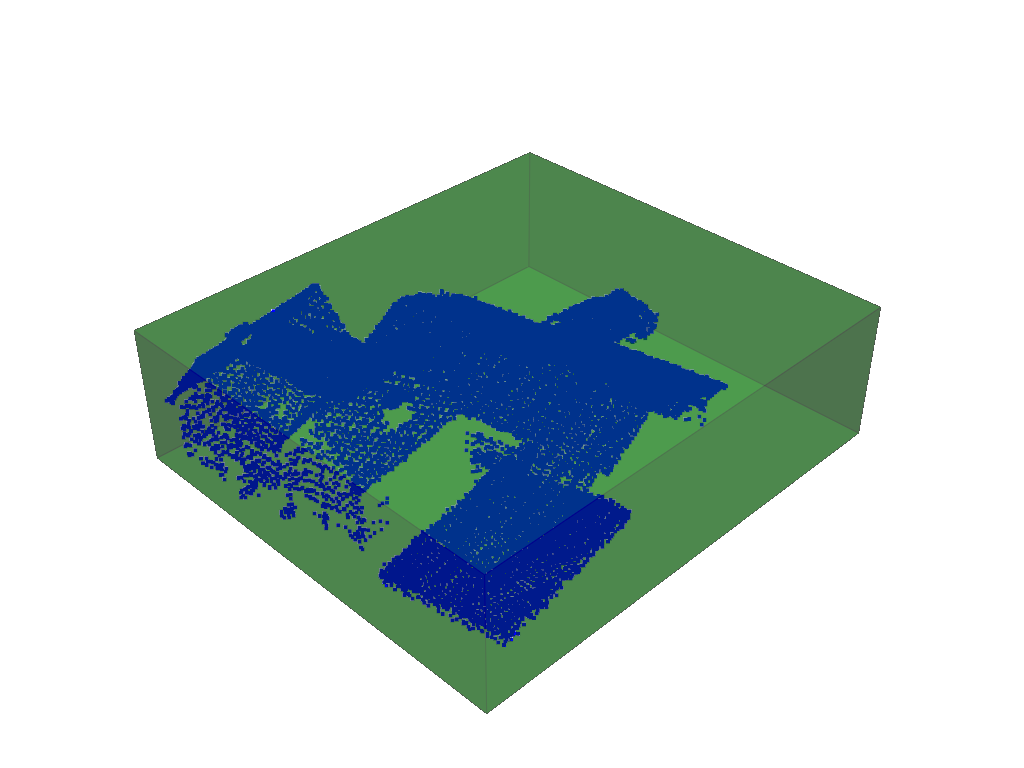

In [ ]:
buildingFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
groundFile = "GeoTileSample/Separated/FullSnip_Rest.ply"
buildingPoints, _ = loadPC(buildingFile)
groundPoints, _   = loadPC(groundFile)
cuboid, img, geo = rasterMinRectCuboid(buildingPoints, groundPoints, pixelSize=0.6, closeSize=3, minComponentArea=40, radius=12.0)

plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(buildingPoints), color="blue", point_size=4)
plotter.add_mesh(cuboid, color="green", opacity=0.45, show_edges=True)
plotter.show()

In [ ]:
#------------------------------------------------------------------------------------------<Save>-------------------------||
cuboid.save("InputOutput/GeoTileMesh_Bldngs_000002_20251113.ply")

### 2.1 Approach 1 : Iterative
Execute the above functions

In [13]:
import os
import glob

In [28]:
tileName = "32CN2_11"

In [ ]:
#D:\Krishna\Research\DigitalTwins\LOD1-Archis\ReconstructedOutputs
commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments"
# bldFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
bldFolder = f"{commonDirectory}/{tileName}/Separated/"
groundFile = f"{commonDirectory}/{tileName}/{tileName}_Ground.ply"
groundPoints, _   = loadPC(groundFile)

outputFolder = f"Outputs/{tileName}"
os.makedirs(outputFolder, exist_ok=True)

bldFiles = glob.glob(os.path.join(bldFolder, "*.ply"))

In [ ]:
for bldFile in bldFiles:
    #buildingFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
    #groundFile = "GeoTileSample/Separated/FullSnip_Rest.ply"
    buildingPoints, _ = loadPC(bldFile)
    cuboid, diag, img, geo = rasterMinRectCuboid(buildingPoints, groundPoints,pixelSize=0.6, closeSize=3, minComponentArea=40, radius=100.0)
    #plotter = pv.Plotter()
    #plotter.add_mesh(pv.PolyData(buildingPoints), color="blue", point_size=4)
    #plotter.add_mesh(cuboid, color="green", opacity=0.45, show_edges=True)
    #plotter.show()
    baseName = os.path.basename(bldFile)
    savePath = f"{outputFolder}/{baseName}"
    cuboid.save(savePath)
    
    print(f"Saved: {savePath}")

Saved: Outputs/32CN2_11/Bldngs__000000.ply
Saved: Outputs/32CN2_11/Bldngs__000001.ply
Saved: Outputs/32CN2_11/Bldngs__000002.ply
Saved: Outputs/32CN2_11/Bldngs__000003.ply
Saved: Outputs/32CN2_11/Bldngs__000004.ply
Saved: Outputs/32CN2_11/Bldngs__000005.ply
Saved: Outputs/32CN2_11/Bldngs__000006.ply
Saved: Outputs/32CN2_11/Bldngs__000007.ply
Saved: Outputs/32CN2_11/Bldngs__000008.ply
Saved: Outputs/32CN2_11/Bldngs__000009.ply
Saved: Outputs/32CN2_11/Bldngs__000010.ply
Saved: Outputs/32CN2_11/Bldngs__000011.ply
Saved: Outputs/32CN2_11/Bldngs__000012.ply
Saved: Outputs/32CN2_11/Bldngs__000013.ply
Saved: Outputs/32CN2_11/Bldngs__000014.ply
Saved: Outputs/32CN2_11/Bldngs__000015.ply
Saved: Outputs/32CN2_11/Bldngs__000016.ply
Saved: Outputs/32CN2_11/Bldngs__000017.ply
Saved: Outputs/32CN2_11/Bldngs__000018.ply
Saved: Outputs/32CN2_11/Bldngs__000019.ply
Saved: Outputs/32CN2_11/Bldngs__000020.ply
Saved: Outputs/32CN2_11/Bldngs__000021.ply
Saved: Outputs/32CN2_11/Bldngs__000022.ply
Saved: Outp

In [31]:
print("Done!")

Done!


### **3.0 Refined Pose Estimation - Approach 2**

**Concept     :**
- Estimate the dominant orientation of the building footprint through directional consensus instead of global fitting.
- Combine edge-based and RANSAC-based direction extraction to detect all prevalent alignment directions.
- Determine the primary building axis through voting over these directions.
- Construct a cuboid aligned with this dominant direction, preserving façade parallelism.

**Methodology :**

- Project building points onto the XY-plane.
- Generate a concave hull (alpha shape) to represent the footprint boundary (fallback to convex)
- Extract edge directions from the hull boundary segments.
- Iteratively apply RANSAC line fitting to contour points to capture linear structures and their orientations
- Collect all angular estimates and perform a voting-based selection to determine the dominant orientation
- Rotate the point cloud to align with this dominant axis
- Compute the axis-aligned bounding cuboid in the rotated frame (using min/max extents)
- Rotate the cuboid back to world coordinates and adjust its base elevation using nearby ground points

In [ ]:
#------------------------------------------------------------------------------------------<Import>-----------------------||
import numpy as np
import open3d as o3d
import alphashape
from shapely.geometry import Polygon, MultiPoint
from scipy.spatial import ConvexHull
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from math import atan2, degrees, radians, sin, cos
import pyvista as pv
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#------------------------------------------------------------------------------------------<Helpers :Rotate, Cuboid>------||
def rotatePoints2D(points, angleDeg, origin=None):
    """Rotate xy points around origin (or centroid if None)"""
    pts = np.asarray(points)
    if origin is None:
        origin = pts.mean(axis=0)
    angleRad = radians(angleDeg)
    R = np.array([[cos(angleRad), -sin(angleRad)], [sin(angleRad), cos(angleRad)]])
    return ((pts - origin) @ R.T) + origin

def createCuboidFromBounds(xMin, xMax, yMin, yMax, zMin, zMax):
    corners = np.array([
        [xMin, yMin, zMin],
        [xMax, yMin, zMin],
        [xMax, yMax, zMin],
        [xMin, yMax, zMin],
        [xMin, yMin, zMax],
        [xMax, yMin, zMax],
        [xMax, yMax, zMax],
        [xMin, yMax, zMax]
    ])
    faces = np.hstack([
        [4, 0, 1, 2, 3],  #bottom
        [4, 4, 5, 6, 7],  # top
        [4, 0, 1, 5, 4],  #1
        [4, 1, 2, 6, 5],  #2
        [4, 2, 3, 7, 6],  #3
        [4, 3, 0, 4, 7]   #4
    ])
    return pv.PolyData(corners, faces)

In [ ]:
#------------------------------------------------------------------------------------------<Angle Estimation>-------------||
def edgeAnglesFromPolygon(hullCoords):
    """Compute angles"""
    coords = np.asarray(hullCoords)
    if coords.shape[0] < 2:
        return []
    if np.allclose(coords[0], coords[-1]):
        coords = coords[:-1]
    angles = []
    for i in range(len(coords)):
        p0 = coords[i]
        p1 = coords[(i+1) % len(coords)]
        dx, dy = p1[0]-p0[0], p1[1]-p0[1]
        if np.hypot(dx, dy) < 1e-6:
            continue
        ang = (degrees(atan2(dy, dx)) + 180.0) % 180.0
        angles.append(ang)
    return angles

In [ ]:
#------------------------------------------------------------------------------------------<RANSAC + Extract angles>------||
def fitLineGetAnglesRANSAC(points2D, residualThreshold=0.25, min_samples=10):
    pts = np.asarray(points2D)
    if len(pts) < 2:
        return None, None
    X = pts[:,0].reshape(-1,1)
    y = pts[:,1]
    try:
        model = make_pipeline(PolynomialFeatures(1), RANSACRegressor(residualThreshold=residualThreshold))
        model.fit(X, y)
        ransac = model.named_steps['ransacregressor']
        estimator = ransac.estimator_
        slope = estimator.coef_[0]
        angle = (degrees(atan2(slope, 1.0)) + 180.0) % 180.0
        mask = ransac.inlier_mask_
        return angle, mask
    except Exception:
        return None, None

def iterativeRANSACAngles(points2D, maxLines=20, residualThreshold=0.25, minInliers=8):
    #Iteratively fit RANSAC lines, remove inliers, collect angles
    pts = np.asarray(points2D).copy()
    angles = []
    for _ in range(maxLines):
        angle, mask = fitLineGetAnglesRANSAC(pts, residualThreshold=residualThreshold)
        if angle is None or mask is None:
            break
        inliers = mask.sum()
        if inliers < minInliers:
            break
        angles.append(angle)
        pts = pts[~mask]
        if len(pts) < minInliers:
            break
    return angles

In [ ]:
#------------------------------------------------------------------------------------------<Angle voting>-----------------||
def voteAngle(allAngles, binWidth=3.0):
    #Angle voting
    if len(allAngles) == 0:
        return 0.0
    bins = np.arange(0.0, 180.0 + binWidth, binWidth)
    hist, edges = np.histogram(allAngles, bins=bins)
    idx = np.argmax(hist)
    center = (edges[idx] + edges[idx+1]) / 2.0
    return center % 180.0

In [ ]:
#------------------------------------------------------------------------------------------<Generate cuboid>--------------||
def buildCuboidWithVotedOrientation(points3D, groundPoints=None,alpha=1.0, ransacResidual=0.25, ransacMinInliers=8,ransacMaxLines=25, angleBin=3.0,hullFallbackToConvex=True):
    pts = np.asarray(points3D)

    #--------------------------------------------------------------------------------------<Grnd Nrmlzn>------------------||
    groundZ = 0.0
    if groundPoints is not None:
        center = pts.mean(axis=0)
        dists = np.linalg.norm(groundPoints[:, :2] - center[:2], axis=1)
        local = groundPoints[dists < 12.0]
        if len(local) >= 5:
            groundZ = np.median(local[:,2])
    normPts = pts.copy()
    normPts[:,2] -= groundZ

    pts2D = normPts[:, :2]

    #--------------------------------------------------------------------------------------<Hull as fallback>-------------||
    try:
        hull = alphashape.alphashape(pts2D, alpha)
        if hull.is_empty:
            raise Exception("empty hull")
        if getattr(hull, 'geom_type', None) == 'MultiPolygon':
            hull = max(hull.geoms, key=lambda p: p.area)
        if not isinstance(hull, Polygon):
            raise Exception("non-polygon hull")
        hullCoords = np.array(hull.exterior.coords)
    except Exception:
        if hullFallbackToConvex:
            ch = ConvexHull(pts2D)
            hullCoords = pts2D[ch.vertices]
        else:
            raise

    #--------------------------------------------------------------------------------------<Iterative RANSAC>-------------||
    edgeAngles = edgeAnglesFromPolygon(hullCoords)
    ransacAngles = iterativeRANSACAngles(hullCoords, maxLines=ransacMaxLines,residualThreshold=ransacResidual, minInliers=ransacMinInliers)
    allAngles = edgeAngles + ransacAngles

    primaryAngle = voteAngle(allAngles, binWidth=angleBin)# voting!!!

    #Compute min/max in rotated frame
    centroid = pts2D.mean(axis=0)
    rotated2D = rotatePoints2D(pts2D, -primaryAngle, origin=centroid)
    rotatedPts = np.hstack((rotated2D, normPts[:,2:3]))

    xMin, xMax = rotatedPts[:,0].min(), rotatedPts[:,0].max()
    yMin, yMax = rotatedPts[:,1].min(), rotatedPts[:,1].max()
    zMin, zMax = rotatedPts[:,2].min(), rotatedPts[:,2].max()

    #Cuboid in rotated frame
    cuboid = createCuboidFromBounds(xMin, xMax, yMin, yMax, zMin, zMax)

    # Rotate cuboid corners back by primaryAngle
    cuboidPts = np.array(cuboid.points)
    
    cuboidXY = cuboidPts[:, :2]
    cuboidXY_back = rotatePoints2D(cuboidXY, primaryAngle, origin=centroid)
    cuboid.points = np.hstack((cuboidXY_back, cuboidPts[:, 2:3] + groundZ)) #Rotate about centroid (XY)

    '''
    diagnostics = {
        "primaryAngle": primaryAngle,
        "edgeAnglesCount": len(edgeAngles),
        "ransacAnglesCount": len(ransacAngles),
        "allAngles": allAngles,
        "centroid": centroid,
        "groundZ": groundZ,
        "rotatedBounds": (xMin, xMax, yMin, yMax, zMin, zMax)
    }
    '''
    
    #return cuboid, diagnostics, hullCoords
    return cuboid, hullCoords

In [ ]:
bldFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
groundFile = "GeoTileSample/Separated/FullSnip_Rest.ply"

pc = o3d.io.read_point_cloud(bldFile)
points = np.asarray(pc.points)

try:
    gpc = o3d.io.read_point_cloud(groundFile)
    groundPts = np.asarray(gpc.points)
except Exception:
    groundPts = None

alpha = 1.0
ransacResidual = 0.25
ransacMinInliers = 8
ransacMaxLines = 25
angleBin = 3.0

cuboid, diag, hullCoords = buildCuboidWithVotedOrientation(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin)

'''
print("Diagnostics:", {k: v for k,v in diag.items() if k != "allAngles"})

cloudPv = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_points(cloudPv, color="white", point_size=2, render_points_as_spheres=True)
plotter.add_mesh(cuboid, color="orange", opacity=0.45, show_edges=True, line_width=1)

try:
    hullXY = np.array(hullCoords)
    z_plot = np.median(points[:,2])
    plotter.add_lines(np.column_stack((hullXY, np.full(len(hullXY), z_plot))), color="red", width=3)
except Exception:
    pass

plotter.show_grid()
plotter.show()
'''

In [ ]:
#------------------------------------------------------------------------------------------<Save>--------------||
cuboid.save("InputOutput/GeoTileMesh_Bldngs_000002_20251113_3.ply")

### **3.0.1 Refined Pose Estimation - Approach 2** - Iterative Version
<span style="color:yellow">Excute all the functions, from the above code, except the main body</span>

In [8]:
import os
import glob

In [21]:
tileName = "32CN2_11"

In [ ]:
#D:\Krishna\Research\DigitalTwins\ReconstructedOutputs
commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments"
# bldFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
bldFolder = f"{commonDirectory}/{tileName}/Separated/"
groundFile = f"{commonDirectory}/{tileName}/{tileName}_Ground.ply"

outputFolder = f"Outputs/{tileName}"
os.makedirs(outputFolder, exist_ok=True)

try:
    gpc = o3d.io.read_point_cloud(groundFile)
    groundPts = np.asarray(gpc.points)
except Exception:
    groundPts = None

In [23]:
bldFiles = glob.glob(os.path.join(bldFolder, "*.ply"))

In [ ]:
for bldFile in bldFiles:
    pc = o3d.io.read_point_cloud(bldFile)
    points = np.asarray(pc.points)
    
    alpha = 1.0
    ransacResidual = 0.25
    ransacMinInliers = 8
    ransacMaxLines = 25
    angleBin = 3.0
    
    cuboid, diag, hullCoords = buildCuboidWithVotedOrientation(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin)
    
    # print("Diagnostics:", {k: v for k,v in diag.items() if k != "allAngles"})
    
    baseName = os.path.basename(bldFile)
    savePath = f"{outputFolder}/{baseName}"
    cuboid.save(savePath)

    print(f"Saved: {savePath}")

In [25]:
print("Done!")

Done!


### **3.1 Refined Pose Estimation - Approach 2**
# <span style="color:yellow">Additional refinement to fix the off ground reconstruction</span>

Major issue with the previous method : if the buildings had very less vertical components, the reconstructed cuboids were off the ground and the estimated pose were bad as well

**Refined using GPT

In [ ]:
#------------------------------------------------------------------------------------------<Imports>----------------------||
import numpy as np
import open3d as o3d
import alphashape
from shapely.geometry import Polygon, MultiPoint
from scipy.spatial import ConvexHull
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from math import atan2, degrees, radians, sin, cos
import pyvista as pv
import warnings

import numpy.linalg as npl
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

In [ ]:
#------------------------------------------------------------------------------------------<Helpers :Rotate, Cuboid>------||
def rotatePoints2D(points, angleDeg, origin=None):
    """Rotate xy points around origin (or centroid if None)"""
    pts = np.asarray(points)
    if origin is None:
        origin = pts.mean(axis=0)
    angleRad = radians(angleDeg)
    R = np.array([[cos(angleRad), -sin(angleRad)], [sin(angleRad), cos(angleRad)]])
    return ((pts - origin) @ R.T) + origin

def createCuboidFromBounds(xMin, xMax, yMin, yMax, zMin, zMax):
    corners = np.array([
        [xMin, yMin, zMin],
        [xMax, yMin, zMin],
        [xMax, yMax, zMin],
        [xMin, yMax, zMin],
        [xMin, yMin, zMax],
        [xMax, yMin, zMax],
        [xMax, yMax, zMax],
        [xMin, yMax, zMax]
    ])
    faces = np.hstack([
        [4, 0, 1, 2, 3],  #bottom
        [4, 4, 5, 6, 7],  # top
        [4, 0, 1, 5, 4],  #1
        [4, 1, 2, 6, 5],  #2
        [4, 2, 3, 7, 6],  #3
        [4, 3, 0, 4, 7]   #4
    ])
    return pv.PolyData(corners, faces)

In [ ]:
#------------------------------------------------------------------------------------------<Angle Estimation>-------------||
def edgeAnglesFromPolygon(hullCoords):
    """Compute angles"""
    coords = np.asarray(hullCoords)
    if coords.shape[0] < 2:
        return []
    if np.allclose(coords[0], coords[-1]):
        coords = coords[:-1]
    angles = []
    for i in range(len(coords)):
        p0 = coords[i]
        p1 = coords[(i+1) % len(coords)]
        dx, dy = p1[0]-p0[0], p1[1]-p0[1]
        if np.hypot(dx, dy) < 1e-6:
            continue
        ang = (degrees(atan2(dy, dx)) + 180.0) % 180.0
        angles.append(ang)
    return angles

In [ ]:
#------------------------------------------------------------------------------------------<RANSAC + Extract angles>------||
def fitLineGetAnglesRANSAC(points2D, residualThreshold=0.25, min_samples=10):
    pts = np.asarray(points2D)
    if len(pts) < 2:
        return None, None
    X = pts[:,0].reshape(-1,1)
    y = pts[:,1]
    try:
        model = make_pipeline(PolynomialFeatures(1), RANSACRegressor(residualThreshold=residualThreshold))
        model.fit(X, y)
        ransac = model.named_steps['ransacregressor']
        estimator = ransac.estimator_
        slope = estimator.coef_[0]
        angle = (degrees(atan2(slope, 1.0)) + 180.0) % 180.0
        mask = ransac.inlier_mask_
        return angle, mask
    except Exception:
        return None, None

def iterativeRANSACAngles(points2D, maxLines=20, residualThreshold=0.25, minInliers=8):
    #Iteratively fit RANSAC lines, remove inliers, collect angles
    pts = np.asarray(points2D).copy()
    angles = []
    for _ in range(maxLines):
        angle, mask = fitLineGetAnglesRANSAC(pts, residualThreshold=residualThreshold)
        if angle is None or mask is None:
            break
        inliers = mask.sum()
        if inliers < minInliers:
            break
        angles.append(angle)
        pts = pts[~mask]
        if len(pts) < minInliers:
            break
    return angles

In [ ]:
#------------------------------------------------------------------------------------------<Angle voting>-----------------||
'''
def voteAngle(allAngles, binWidth=3.0):
    #Circular voting
    if len(allAngles) == 0:
        return 0.0
    bins = np.arange(0.0, 180.0 + binWidth, binWidth)
    hist, edges = np.histogram(allAngles, bins=bins)
    idx = np.argmax(hist)
    center = (edges[idx] + edges[idx+1]) / 2.0
    return center % 180.0
'''

'''Instead circular voting for undirected angles (0 == 180)'''
def voteAngleCircular(allAngles, binWidth=3.0):
    angs = np.asarray(allAngles, dtype=float)
    if angs.size == 0:
        return 0.0
    
    angs = np.mod(angs, 180.0) #Fit angles within 0,180 range

    #map theta -> 2*theta on unit circle, compute mean angle, then half
    angsRad = np.deg2rad(angs)
    vecs = np.exp(2j * angsRad)
    meanVec = np.mean(vecs)

    if np.abs(meanVec) < 1e-6: #Fallback to histogram
        bins = np.arange(0.0, 180.0 + binWidth, binWidth)
        hist, edges = np.histogram(angs, bins=bins)
        idx = np.argmax(hist)
        center = (edges[idx] + edges[idx+1]) / 2.0
        return center % 180.0
    meanAngle2 = np.angle(meanVec)
    primaryRad = meanAngle2 / 2.0
    primaryDeg = np.rad2deg(primaryRad) % 180.0
    return primaryDeg

In [ ]:
#------------------------------------------------------------------------------------------<PCA as fallback for angle>----||
def principalAxisAngle2D(points2D):
    pts = np.asarray(points2D)
    if len(pts) < 2:
        return 0.0
    try:
        pca = PCA(n_components=2)
        pca.fit(pts)
        # first component vector
        v = pca.components_[0]
        ang = (np.degrees(np.arctan2(v[1], v[0])) + 180.0) % 180.0
        return ang
    except Exception:
        return 0.0

In [ ]:
'''buildCuboidWithVotedOrientation_Patched(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin,verticalThreshold=1.0,minBuildingHeight=2.5)'''

#Refined using GPT

def buildCuboidWithVotedOrientation_Patched(points3D, groundPoints=None,alpha=1.0, ransacResidual=0.25, ransacMinInliers=8,ransacMaxLines=25, angleBin=3.0,hullFallbackToConvex=True,verticalThreshold=1.0,minBuildingHeight=2.5,groundSearchRadius=12.0,groundPercentile=20.0,ransacInlierRatioThreshold=0.15):
    """
    Upgrades :
      - roof only detection
      - robust circular voting
      - PCA fallback when weak evidence
      - ground plane fitting (sloped terrain)
      - cuboid bottom snapping to ground plane
    """

    pts = np.asarray(points3D)
    diagnostics = {}

    groundZ = 0.0
    if groundPoints is not None and len(groundPoints) > 0:
        center = pts.mean(axis=0)
        dists = np.linalg.norm(groundPoints[:, :2] - center[:2], axis=1)
        local = groundPoints[dists < groundSearchRadius]
        if len(local) >= 5:
            groundZ = np.percentile(local[:,2], groundPercentile)
        else:
            groundZ = np.median(groundPoints[:,2])
    diagnostics['groundZ'] = float(groundZ)

    normPts = pts.copy()
    normPts[:,2] -= groundZ
    pts2D = normPts[:, :2]

    #Sloped ground
    a = b = 0.0
    c = groundZ
    localGroundPlaneOK = False

    if groundPoints is not None and len(groundPoints) > 0:
        centerXY = pts[:, :2].mean(axis=0)
        dists = np.linalg.norm(groundPoints[:, :2] - centerXY, axis=1)
        localGround = groundPoints[dists < groundSearchRadius]

        if len(localGround) >= 5:
            A = np.c_[localGround[:,0], localGround[:,1], np.ones(len(localGround))]
            C,_,_,_ = np.linalg.lstsq(A, localGround[:,2], rcond=None)
            a, b, c = C
            localGroundPlaneOK = True

    diagnostics['groundPlane'] = {
        'a': float(a), 'b': float(b), 'c': float(c),
        'localGroundPlaneOK': bool(localGroundPlaneOK)
    }

    #compute hull (concave) with fallback
    try:
        hull = alphashape.alphashape(pts2D, alpha)
        if hull.is_empty:
            raise Exception("empty hull")
        if getattr(hull, 'geom_type', None) == 'MultiPolygon':
            hull = max(hull.geoms, key=lambda p: p.area)
        if not isinstance(hull, Polygon):
            raise Exception("non-polygon hull")
        hullCoords = np.array(hull.exterior.coords)
    except Exception:
        if hullFallbackToConvex:
            ch = ConvexHull(pts2D)
            hullCoords = pts2D[ch.vertices]
        else:
            raise

    #Collect orientation evidence
    edgeAngles = edgeAnglesFromPolygon(hullCoords)
    ransacAngles = iterativeRANSACAngles(
        hullCoords, maxLines=ransacMaxLines,
        residualThreshold=ransacResidual, minInliers=ransacMinInliers)

    diagnostics['edgeAngles'] = edgeAngles
    diagnostics['ransacAngles'] = ransacAngles
    diagnostics['edgeAnglesCount'] = len(edgeAngles)
    diagnostics['ransacAnglesCount'] = len(ransacAngles)

    allAngles = list(edgeAngles) + list(ransacAngles)

    #Circular voting
    primaryAngle = voteAngleCircular(allAngles, binWidth=angleBin)
    diagnostics['primaryAngle_raw'] = float(primaryAngle)

    #Vertical span
    zMinObs = normPts[:,2].min()
    zMaxObs = normPts[:,2].max()
    verticalSpan = zMaxObs - zMinObs
    diagnostics['zMinObs'] = float(zMinObs)
    diagnostics['zMaxObs'] = float(zMaxObs)
    diagnostics['verticalSpan'] = float(verticalSpan)

    roofOnlyFlag = verticalSpan < verticalThreshold
    diagnostics['roofOnlyFlag'] = bool(roofOnlyFlag)

    #PCA fallback
    fallbackToPCA = False
    evidencePresent = len(allAngles) > 0

    if evidencePresent:
        angsRad = np.deg2rad(np.mod(allAngles, 180.0))
        resultant = np.abs(np.mean(np.exp(2j * angsRad)))
        diagnostics['circularResultant'] = float(resultant)
        if resultant < 0.25:
            fallbackToPCA = True
    else:
        diagnostics['circularResultant'] = 0.0
        fallbackToPCA = True

    # RANSAC inlier strength
    hullPtCount = len(hullCoords)
    totalRansacInliers = 0

    try:
        ptsHull = np.asarray(hullCoords)
        for _ in range(ransacMaxLines):
            angleR, maskR = fitLineGetAnglesRANSAC(ptsHull, residualThreshold=ransacResidual, min_samples=3)
            if angleR is None or maskR is None:
                break
            inliers = maskR.sum()
            if inliers < ransacMinInliers:
                break
            totalRansacInliers += int(inliers)
            ptsHull = ptsHull[~maskR]
            if len(ptsHull) < ransacMinInliers:
                break
    except Exception:
        pass

    diagnostics['totalRansacInliers'] = int(totalRansacInliers)
    diagnostics['hullPtCount'] = int(hullPtCount)

    inlierRatio = (totalRansacInliers / float(max(hullPtCount, 1))) if hullPtCount > 0 else 0.0
    diagnostics['ransacInlierRatio'] = float(inlierRatio)

    if inlierRatio < ransacInlierRatioThreshold:
        fallbackToPCA = True

    # Get final orientation
    fallbackReason = None
    if roofOnlyFlag:
        fallbackReason = "roofOnly"
    if fallbackToPCA and not fallbackReason:
        fallbackReason = "weakAngularConsensus"

    if fallbackReason:
        pcaAngle = principalAxisAngle2D(
            hullCoords if len(hullCoords) > 0 else pts2D)
        diagnostics['fallbackReason'] = fallbackReason
        diagnostics['pcaAngle'] = float(pcaAngle)
        primaryAngle = pcaAngle

    diagnostics['primaryAngle'] = float(primaryAngle)

    #Rotate to xompute AABB
    centroid = pts2D.mean(axis=0)
    rotated2D = rotatePoints2D(pts2D, -primaryAngle, origin=centroid)
    rotatedPts = np.hstack((rotated2D, normPts[:,2:3]))

    xMin, xMax = rotatedPts[:,0].min(), rotatedPts[:,0].max()
    yMin, yMax = rotatedPts[:,1].min(), rotatedPts[:,1].max()
    zMin, zMax = rotatedPts[:,2].min(), rotatedPts[:,2].max()

    diagnostics['rotatedBounds_beforeFix'] = (
        float(xMin), float(xMax), float(yMin), float(yMax), float(zMin), float(zMax)
    )

    #  Vertical extent fixing: roof-only / normal case
    if roofOnlyFlag:
        zMin = 0.0
        zMax = max(zMax, zMin + minBuildingHeight)
        diagnostics['roofOnlyAdjusted_zMin'] = float(zMin)
        diagnostics['roofOnlyAdjusted_zMax'] = float(zMax)
    else:
        zMin = min(zMin, 0.0)
        diagnostics['nonRoof_zMin_used'] = float(zMin)
        diagnostics['nonRoof_zMax_used'] = float(zMax)

    #Compute cuboid in rotated frame
    cuboid = createCuboidFromBounds(float(xMin), float(xMax), float(yMin), float(yMax),float(zMin), float(zMax))

    # Rotate cuboid back to world coords
    cuboidPts = np.array(cuboid.points)
    cuboidXY = cuboidPts[:, :2]
    cuboidXY_back = rotatePoints2D(cuboidXY, primaryAngle, origin=centroid)
    cuboid.points = np.hstack((cuboidXY_back, cuboidPts[:, 2:3] + groundZ))

    # Snap cuboid to ground
    if localGroundPlaneOK:
        ptsC = np.array(cuboid.points)
        XY = ptsC[:, :2]

        groundZ_vals = a * XY[:,0] + b * XY[:,1] + c #Plane height at each cuboid vertex

        ptsC[:,2] = np.maximum(ptsC[:,2], groundZ_vals) #Bottom  to ground plane

        cuboid.points = ptsC
        diagnostics['groundSnapApplied'] = True
    else:
        diagnostics['groundSnapApplied'] = False

    diagnostics['centroid'] = centroid.tolist()
    diagnostics['rotatedBounds'] = (
        float(xMin), float(xMax), float(yMin), float(yMax), float(zMin), float(zMax)
    )

    return cuboid, diagnostics, hullCoords

Diagnostics: {'groundZ': 6.6976, 'groundPlane': {'a': -0.002408459858502198, 'b': -6.773228161867243e-05, 'c': 571.2905614380442, 'localGroundPlaneOK': True}, 'edgeAnglesCount': 241, 'ransacAnglesCount': 7, 'primaryAngle_raw': 160.36612719443056, 'zMinObs': 2.1894, 'zMaxObs': 6.7594, 'verticalSpan': 4.57, 'roofOnlyFlag': False, 'circularResultant': 0.4686055713811037, 'totalRansacInliers': 205, 'hullPtCount': 242, 'ransacInlierRatio': 0.8471074380165289, 'primaryAngle': 160.36612719443056, 'rotatedBounds_beforeFix': (220438.51020702973, 220484.84537400652, 495824.23629058327, 495842.1326342365, 2.1894, 6.7594), 'nonRoof_zMin_used': 0.0, 'nonRoof_zMax_used': 6.7594, 'groundSnapApplied': True, 'centroid': [220461.75298559954, 495832.9189726013], 'rotatedBounds': (220438.51020702973, 220484.84537400652, 495824.23629058327, 495842.1326342365, 0.0, 6.7594)}


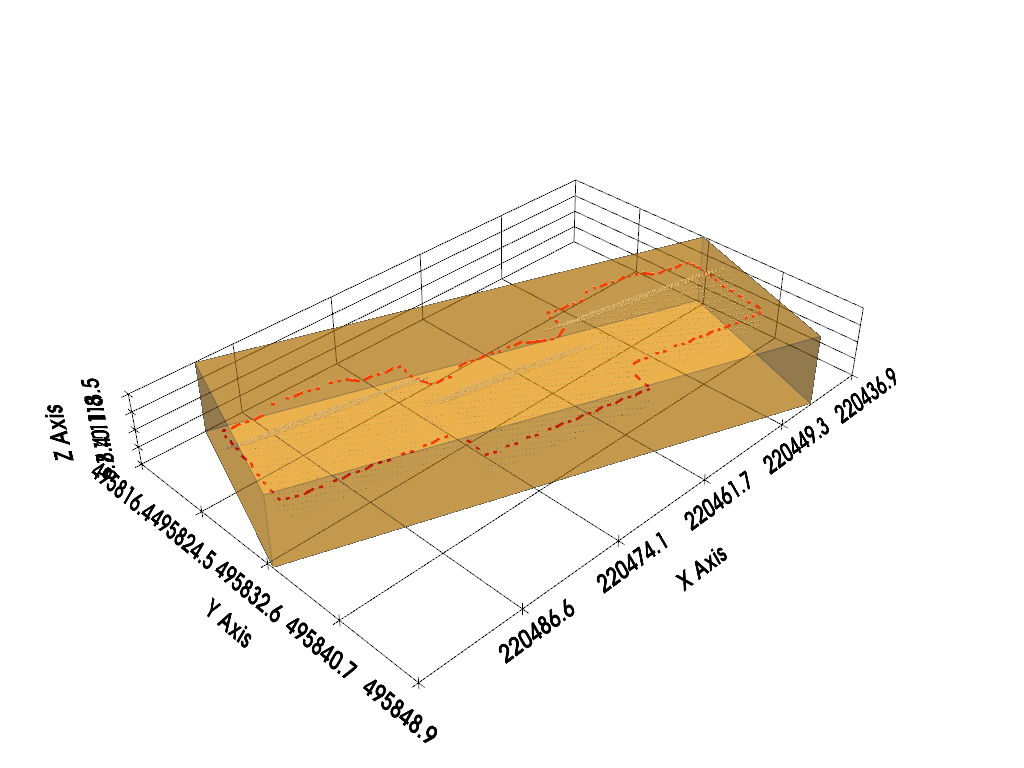

In [ ]:
#commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments"
bldFile = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments/28AN1_16/Separated/Bldngs__000049.ply"
groundFile = "/mnt/d/Krishna/Research/DigitalTwins/DataForExperiments/28AN1_16/28AN1_16_Ground.ply"

pc = o3d.io.read_point_cloud(bldFile)
points = np.asarray(pc.points)

try:
    gpc = o3d.io.read_point_cloud(groundFile)
    groundPts = np.asarray(gpc.points)
except Exception:
    groundPts = None

alpha = 1.0
ransacResidual = 0.25
ransacMinInliers = 8
ransacMaxLines = 25
angleBin = 3.0

'''cuboid, diag, hullCoords = buildCuboidWithVotedOrientation(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin)

print("Diagnostics:", {k: v for k,v in diag.items() if k != "allAngles"})
'''

cuboid, diag, hullCoords = buildCuboidWithVotedOrientation_Patched(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin,verticalThreshold=1.0,minBuildingHeight=2.5)

print("Diagnostics:", {k: v for k, v in diag.items() if k not in ['edgeAngles','ransacAngles','allAngles']})

cloudPv = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_points(cloudPv, color="white", point_size=2, render_points_as_spheres=True)
plotter.add_mesh(cuboid, color="orange", opacity=0.45, show_edges=True, line_width=1)

try:
    hullXY = np.array(hullCoords)
    z_plot = np.median(points[:,2])
    plotter.add_lines(np.column_stack((hullXY, np.full(len(hullXY), z_plot))), color="red", width=3)
except Exception:
    pass

plotter.show_grid()
plotter.show()

In [ ]:
#------------------------------------------------------------------------------------------<Save>-------------------------||
cuboid.save("Outputs/28AN1_16_Bldngs__000049.ply")

### **3.1.1 Refined Pose Estimation - Approach 2**
# <span style="color:yellow">Above method + Iterative + Execute the respective fNs above</span>

In [14]:
import os
import glob

In [25]:
tileName = "32CN2_11"

In [ ]:
#D:\Krishna\Research\DigitalTwins\LOD1-Archis\ReconstructedOutputs
commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments"
# bldFile = "GeoTileSample/Buildings PC/FullSnip_Bldngs_000002.ply"
bldFolder = f"{commonDirectory}/{tileName}/Separated/"
groundFile = f"{commonDirectory}/{tileName}/{tileName}_Ground.ply"

outputFolder = f"Outputs/{tileName}"
os.makedirs(outputFolder, exist_ok=True)

try:
    gpc = o3d.io.read_point_cloud(groundFile)
    groundPts = np.asarray(gpc.points)
except Exception:
    groundPts = None

In [27]:
bldFiles = glob.glob(os.path.join(bldFolder, "*.ply"))

In [ ]:
for bldFile in bldFiles:
    pc = o3d.io.read_point_cloud(bldFile)
    points = np.asarray(pc.points)
    
    alpha = 1.0
    ransacResidual = 0.25
    ransacMinInliers = 8
    ransacMaxLines = 25
    angleBin = 3.0
    
    cuboid, diag, hullCoords = buildCuboidWithVotedOrientation_Patched(points, groundPoints=groundPts,alpha=alpha,ransacResidual=ransacResidual,ransacMinInliers=ransacMinInliers,ransacMaxLines=ransacMaxLines,angleBin=angleBin,verticalThreshold=1.0,minBuildingHeight=2.5)
    
    #print("Diagnostics:", {k: v for k, v in diag.items() if k not in ['edgeAngles','ransacAngles','allAngles']})
    
    baseName = os.path.basename(bldFile)
    savePath = f"{outputFolder}/{baseName}"
    cuboid.save(savePath)

    print(f"Saved: {savePath}")

Saved: Outputs/32CN2_11/Bldngs__000000.ply
Saved: Outputs/32CN2_11/Bldngs__000001.ply
Saved: Outputs/32CN2_11/Bldngs__000002.ply
Saved: Outputs/32CN2_11/Bldngs__000003.ply
Saved: Outputs/32CN2_11/Bldngs__000004.ply
Saved: Outputs/32CN2_11/Bldngs__000005.ply
Saved: Outputs/32CN2_11/Bldngs__000006.ply
Saved: Outputs/32CN2_11/Bldngs__000007.ply
Saved: Outputs/32CN2_11/Bldngs__000008.ply
Saved: Outputs/32CN2_11/Bldngs__000009.ply
Saved: Outputs/32CN2_11/Bldngs__000010.ply
Saved: Outputs/32CN2_11/Bldngs__000011.ply
Saved: Outputs/32CN2_11/Bldngs__000012.ply
Saved: Outputs/32CN2_11/Bldngs__000013.ply
Saved: Outputs/32CN2_11/Bldngs__000014.ply
Saved: Outputs/32CN2_11/Bldngs__000015.ply
Saved: Outputs/32CN2_11/Bldngs__000016.ply
Saved: Outputs/32CN2_11/Bldngs__000017.ply
Saved: Outputs/32CN2_11/Bldngs__000018.ply
Saved: Outputs/32CN2_11/Bldngs__000019.ply
Saved: Outputs/32CN2_11/Bldngs__000020.ply
Saved: Outputs/32CN2_11/Bldngs__000021.ply
Saved: Outputs/32CN2_11/Bldngs__000022.ply
Saved: Outp

Saved: Outputs/32CN2_11/Bldngs__000085.ply
Saved: Outputs/32CN2_11/Bldngs__000086.ply
Saved: Outputs/32CN2_11/Bldngs__000087.ply
Saved: Outputs/32CN2_11/Bldngs__000088.ply
Saved: Outputs/32CN2_11/Bldngs__000089.ply
Saved: Outputs/32CN2_11/Bldngs__000090.ply
Saved: Outputs/32CN2_11/Bldngs__000091.ply
Saved: Outputs/32CN2_11/Bldngs__000092.ply
Saved: Outputs/32CN2_11/Bldngs__000093.ply
Saved: Outputs/32CN2_11/Bldngs__000094.ply
Saved: Outputs/32CN2_11/Bldngs__000095.ply
Saved: Outputs/32CN2_11/Bldngs__000096.ply
Saved: Outputs/32CN2_11/Bldngs__000097.ply
Saved: Outputs/32CN2_11/Bldngs__000098.ply
Saved: Outputs/32CN2_11/Bldngs__000099.ply
Saved: Outputs/32CN2_11/Bldngs__000100.ply
Saved: Outputs/32CN2_11/Bldngs__000101.ply
Saved: Outputs/32CN2_11/Bldngs__000102.ply
Saved: Outputs/32CN2_11/Bldngs__000103.ply
Saved: Outputs/32CN2_11/Bldngs__000104.ply
Saved: Outputs/32CN2_11/Bldngs__000105.ply
Saved: Outputs/32CN2_11/Bldngs__000106.ply
Saved: Outputs/32CN2_11/Bldngs__000107.ply
Saved: Outp

In [29]:
print("Done!")

Done!


### **4.0 Refined Pose Estimation - Approach 3**
## <span style="color:yellow">Best fitting rectangle to Mesh</span>

In [1]:
fName = "Bldngs__000008"
tileName = "28AN1_16"

In [ ]:
#------------------------------------------------------------------------------------------<Import>-----------------------||
import numpy as np
import open3d as o3d
from shapely.geometry import Polygon
import pyvista as pv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#------------------------------------------------------------------------------------------<Grounding>--------------------||
def estimateGroundZ(nearGround, minGroundPts):
    if len(nearGround) >= minGroundPts:
        groundZ = np.mean(nearGround[:, 2])
        groundSource = "local mean"
    
        print("Option 1")
    else:
        print(f"{len(nearGround)} ground pts found")
        groundZ = np.min(groundPoints[:, 2])
        groundSource = "global ground min"
    
        print("Option 2")

    if not np.isfinite(groundZ):
        print("Falling back to building min Z")
        groundZ = np.min(bldPoints[:, 2])
        groundSource = "building min Z"
    
        print("Option 3")
        
    print(f"Ground Z used: {groundZ:.3f} ({groundSource})")

    return groundZ, groundSource

In [ ]:
#------------------------------------------------------------------------------------------<Cuboid boundaries>------------||
def computeCuboidBoundaries(bldPoints, groundZ):
    bldPointsGrounded = bldPoints.copy()
    bldPointsGrounded[:, 2] -= groundZ #grndng
    
    #Projected points for footprint
    pointsXY = bldPoints[:, :2]
    pointsOnGround = np.hstack([
        pointsXY,
        np.full((pointsXY.shape[0], 1), groundZ)
    ])
    
    #Compute Minimum-Area Rectangle
    hull = Polygon(pointsXY).convex_hull
    minRect = hull.minimum_rotated_rectangle
    
    rectCoords = np.array(minRect.exterior.coords) 
    rectCoords3D = np.hstack([
        rectCoords[:, :2],
        np.full((len(rectCoords), 1), groundZ)
    ])
    
    #Compute Cuboid Height
    maxHeightAboveGround = np.max(bldPointsGrounded[:, 2])
    
    if maxHeightAboveGround <= 0:
        print("No heiught")
        maxHeightAboveGround = np.ptp(bldPoints[:, 2])  # fallback
    
    print(f"Building height : {maxHeightAboveGround:.3f}")

    return rectCoords3D, maxHeightAboveGround

In [ ]:
#------------------------------------------------------------------------------------------<Generate Mesh>----------------||
def generateMesh(rectCoords3D, groundZ, maxHeightAboveGround):
    bottom = rectCoords3D
    top = rectCoords3D.copy()
    top[:, 2] = groundZ + maxHeightAboveGround
    
    cuboidPoints = np.vstack([bottom, top])
    
    faces = []
    numVerts = len(bottom)
    N = numVerts - 1      
    
    faces.append(np.hstack([[numVerts], np.arange(0, numVerts)])) # Bottom face
    faces.append(np.hstack([[numVerts], np.arange(numVerts, 2 * numVerts)])) #Top face
    
    for i in range(N): # Side faces
        b1, b2 = i, i + 1
        t1, t2 = i + numVerts, i + 1 + numVerts
        faces.append(np.array([4, b1, b2, t2, t1]))
    
    faces = np.hstack(faces)
    cuboid = pv.PolyData(cuboidPoints, faces)

    return cuboid

In [6]:
bldFile = f"/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/28AN1_16/Separated/{fName}.ply"
groundFile = "/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/28AN1_16/28AN1_16_Ground.ply"
outputFile = f"Outputs/{tileName}_{fName}.ply"

In [ ]:
#----------------------------------------------------------------------------------------<Parameters>----------------------||
radius = 15.0 # 8.0 # Local ground search ----> For grounding
minGroundPts = 10   # Min reqd grnd pts

In [ ]:
bldPC = o3d.io.read_point_cloud(bldFile)
groundPC = o3d.io.read_point_cloud(groundFile)

bldPoints = np.asarray(bldPC.points)
groundPoints = np.asarray(groundPC.points)

bldCentroidXY = np.mean(bldPoints[:, :2], axis=0) #Compute centroid

distXY = np.linalg.norm(groundPoints[:, :2] - bldCentroidXY, axis=1) #Estimate ground points from radial neighbourhood
nearGround = groundPoints[distXY <= radius]
groundZ, groundSource = estimateGroundZ(nearGround, minGroundPts)

rectCoords3D, maxHeightAboveGround = computeCuboidBoundaries(bldPoints, groundZ) #Compute height and coord of vertices

cuboid = generateMesh(rectCoords3D, groundZ, maxHeightAboveGround) #Generate mesh

cuboidTri = cuboid.triangulate()
cuboidTri.save(outputFile)

print("Saved cuboid:", outputFile)

Option 1
Ground Z used: 6.888 (local mean)
Building height : 10.233
Saved cuboid: Outputs/28AN1_16_Bldngs__000008.ply


### **4.1 Refined Pose Estimation - Approach 3**
## <span style="color:yellow">Best fitting rectangle -> Then to Mesh</span><span style="color:blue"> + Iterative (Run the above fNs)</span>

In [9]:
import os
import glob

In [22]:
tileName = "32CN2_11"

In [23]:
commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments"

bldFolder = f"{commonDirectory}/{tileName}/Separated/"
groundFile = f"{commonDirectory}/{tileName}/{tileName}_Ground.ply"

outputFolder = f"Outputs/{tileName}"
os.makedirs(outputFolder, exist_ok=True)

In [ ]:
#----------------------------------------------------------------------------------------<Parameters>----------------------||
radius = 15.0 # 8.0 # Local ground search ----> For grounding
minGroundPts = 10   # Min reqd grnd pts

groundPC = o3d.io.read_point_cloud(groundFile)
groundPoints = np.asarray(groundPC.points)

In [25]:
bldFiles = glob.glob(os.path.join(bldFolder, "*.ply"))

In [ ]:
for bldFile in bldFiles:
    bldPC = o3d.io.read_point_cloud(bldFile)
    bldPoints = np.asarray(bldPC.points)
    
    bldCentroidXY = np.mean(bldPoints[:, :2], axis=0) #Compute centroid
    
    distXY = np.linalg.norm(groundPoints[:, :2] - bldCentroidXY, axis=1) #Estimate ground points from radial neighbourhood
    nearGround = groundPoints[distXY <= radius]
    groundZ, groundSource = estimateGroundZ(nearGround, minGroundPts)
    
    rectCoords3D, maxHeightAboveGround = computeCuboidBoundaries(bldPoints, groundZ) #Compute height and coord of vertices
    
    cuboid = generateMesh(rectCoords3D, groundZ, maxHeightAboveGround) #Generate mesh
    
    cuboidTri = cuboid.triangulate()
    #cuboidTri.save(outputFile)

    baseName = os.path.basename(bldFile)
    savePath = f"{outputFolder}/{baseName}"
    cuboidTri.save(savePath)
    
    print("Saved cuboid:", savePath)

In [27]:
print("Done!")

Done!


### **5.0 Refined Pose Estimation - Approach 4**
## <span style="color:yellow">Contour based estimation and refinement</span>

In [ ]:
#----------------------------------------------------------------------------------------<Imports>-------------------------||
import numpy as np
import open3d as o3d
from shapely.geometry import Polygon
import pyvista as pv



#----------------------------------------------------------------------------------------<Parameters>----------------------||
fName = "Bldngs__000102"
tileName = "28AN1_16"

bldFile = f"/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/{tileName}/Separated/{fName}.ply"
groundFile = f"/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/{tileName}/{tileName}_Ground.ply"

radius = 15.0       
minGroundPts = 10   

#------------------------------Ridge extraction parameters
basePercentile = 95 #90      # initial height percentile
minRidgePts = 20 #30         # min ridge points reqd
maxRidgeFrac = 0.25          # max fraction of building pts allowed

In [ ]:
#----------------------------------------------------------------------------------------<Utility Functions>---------------||
def estimateGroundZ(nearGround, groundPoints, bldPoints, minGroundPts):
    if len(nearGround) >= minGroundPts:
        groundZ = np.mean(nearGround[:, 2])
        groundSource = "local mean"
        print("Option 1 - local mean")

    else:
        print(f"Only {len(nearGround)} ground points found ---> fallback!!!")
        groundZ = np.min(groundPoints[:, 2])
        groundSource = "global ground min"
        print("Option 2 - global min")

    if not np.isfinite(groundZ):
        print("Invalid groundZ --> Falling back to building min Z")
        groundZ = np.min(bldPoints[:, 2])
        groundSource = "building min Z"
        print("Option 3 - building min")

    print(f"Ground Z used: {groundZ:.3f} ({groundSource})")
    return groundZ, groundSource

#Ridge candidate points extraction using adaptive percentile-based height thresholding
def extractRidgeCandidates(bldPoints, groundZ,basePercentile=90,minRidgePts=30,maxRidgeFrac=0.25):
    #Normalize Heights
    bldPointsGrounded = bldPoints.copy()
    bldPointsGrounded[:, 2] -= groundZ

    zVals = bldPointsGrounded[:, 2]
    validMask = zVals > 0
    zVals = zVals[validMask]

    if len(zVals) == 0:
        print("No valid ground points found above")
        return None, None

    # Initial Percentile Threshold
    percentileUsed = basePercentile
    zThresh = np.percentile(zVals, percentileUsed)

    ridgeMask = bldPointsGrounded[:, 2] >= zThresh
    ridgePoints = bldPoints[ridgeMask]

    totalPts = len(bldPoints)
    ridgeCount = len(ridgePoints)

    # Adaptive Adjustment
    if ridgeCount < minRidgePts:
        percentileUsed = max(85, basePercentile - 5)
        zThresh = np.percentile(zVals, percentileUsed)
        ridgeMask = bldPointsGrounded[:, 2] >= zThresh
        ridgePoints = bldPoints[ridgeMask]

    elif ridgeCount > maxRidgeFrac * totalPts:
        percentileUsed = min(95, basePercentile + 5)
        zThresh = np.percentile(zVals, percentileUsed)
        ridgeMask = bldPointsGrounded[:, 2] >= zThresh
        ridgePoints = bldPoints[ridgeMask]

    ridgeCount = len(ridgePoints)

    print("Ridge extraction summary:")
    print(f"  Percentile used : P{percentileUsed}")
    print(f"  Height threshold: {zThresh:.3f}")
    print(f"  Ridge points    : {ridgeCount}/{totalPts}")

    if ridgeCount < minRidgePts:
        print("Few ridge candidates!!")

    return ridgePoints, percentileUsed

In [ ]:
bldPC = o3d.io.read_point_cloud(bldFile)
groundPC = o3d.io.read_point_cloud(groundFile)

bldPoints = np.asarray(bldPC.points)
groundPoints = np.asarray(groundPC.points)

bldCentroidXY = np.mean(bldPoints[:, :2], axis=0)
distXY = np.linalg.norm(groundPoints[:, :2] - bldCentroidXY, axis=1)
nearGround = groundPoints[distXY <= radius]

groundZ, groundSource = estimateGroundZ(nearGround,groundPoints,bldPoints,minGroundPts)

ridgePoints, ridgePercentile = extractRidgeCandidates(bldPoints,groundZ,basePercentile=basePercentile,minRidgePts=minRidgePts,maxRidgeFrac=maxRidgeFrac)

Option 1 - local mean
Ground Z used: 6.360 (local mean)
Ridge extraction summary:
  Percentile used : P95
  Height threshold: 8.011
  Ridge points    : 131/2609


In [ ]:
#----------------------------------------------------------------------------------------<Ridge Direction Estimation>------||
def fitLineRANSAC(pointsXY, maxIterations=500, distanceThresh=0.3):
    #Simple RANSAC-based 2D line fitting
    bestInliers = []
    bestDir = None

    N = pointsXY.shape[0]

    if N < 2:
        return None, 0.0

    for _ in range(maxIterations):
        idx = np.random.choice(N, 2, replace=False)
        p1, p2 = pointsXY[idx]

        dirVec = p2 - p1
        norm = np.linalg.norm(dirVec)
        if norm == 0:
            continue
        dirVec /= norm

        diffs = pointsXY - p1
        cross = np.abs(diffs[:, 0] * dirVec[1] - diffs[:, 1] * dirVec[0])
        inliers = np.where(cross < distanceThresh)[0]

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            bestDir = dirVec

    inlierRatio = len(bestInliers) / N if N > 0 else 0.0
    return bestDir, inlierRatio


def estimateRidgeDirection(ridgePoints,minPts=20,ransacInlierThresh=0.4,eigenRatioThresh=5.0):
    #Estimate dominant ridge direction using RANSAC with PCA fallback

    if ridgePoints is None or len(ridgePoints) < minPts:
        print("Not enough ridge points for direction estimation!!!")
        return None, "insufficient_points", 0.0

    pointsXY = ridgePoints[:, :2]

    #RANSAC Line Fitting
    dirVec, inlierRatio = fitLineRANSAC(pointsXY)

    if dirVec is not None and inlierRatio >= ransacInlierThresh:
        theta = np.arctan2(dirVec[1], dirVec[0])
        print(f"Direction estimated using RANSAC (inlier ratio = {inlierRatio:.2f})")
        return theta, "ransac", inlierRatio

    #PCA Fallback
    centered = pointsXY - np.mean(pointsXY, axis=0)
    cov = np.cov(centered.T)
    eigVals, eigVecs = np.linalg.eigh(cov)

    idx = np.argsort(eigVals)[::-1]
    eigVals = eigVals[idx]
    eigVecs = eigVecs[:, idx]

    if eigVals[1] <= 0:
        print("Degenerate PCA eigenvalues")
        return None, "degenerate_pca", 0.0

    eigenRatio = eigVals[0] / eigVals[1]

    if eigenRatio >= eigenRatioThresh:
        principalDir = eigVecs[:, 0]
        theta = np.arctan2(principalDir[1], principalDir[0])
        print(f"Direction estimated using PCA (eigen ratio = {eigenRatio:.2f})")
        return theta, "pca", eigenRatio

    #Failed...
    print("Ambiguous ridges")
    return None, "ambiguous", eigenRatio


In [ ]:
theta, directionMethod, confidence = estimateRidgeDirection(
    ridgePoints,
    minPts=20,
    ransacInlierThresh=0.4,
    eigenRatioThresh= 2.0 #5.0
)

if theta is not None:
    print(f"Estimated ridge orientation (rad): {theta:.4f}")
    print(f"Method used: {directionMethod}, confidence: {confidence:.3f}")
else:
    print("Ridge based angle est. failed -> Fallback!!!")


Ambiguous ridges
Ridge based angle est. failed -> Fallback!!!


In [ ]:
#----------------------------------------------------------------------------------------<Helper functions>----------------||
def rotatePointsXY(points, theta):
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

    rotatedXY = points[:, :2] @ R.T
    rotatedPoints = points.copy()
    rotatedPoints[:, :2] = rotatedXY

    return rotatedPoints


def computeAxisAlignedCuboid(bldPoints, groundZ):
    heights = bldPoints[:, 2] - groundZ
    maxHeight = np.max(heights)

    if maxHeight <= 0:
        print("No height --> Z-range fallback!!")
        maxHeight = np.ptp(bldPoints[:, 2])

    # XY bounds
    minXY = np.min(bldPoints[:, :2], axis=0)
    maxXY = np.max(bldPoints[:, :2], axis=0)

    rectCoords = np.array([
        [minXY[0], minXY[1], groundZ],
        [maxXY[0], minXY[1], groundZ],
        [maxXY[0], maxXY[1], groundZ],
        [minXY[0], maxXY[1], groundZ],
        [minXY[0], minXY[1], groundZ]  # closed polygon
    ])

    return rectCoords, maxHeight


def generateCuboidMesh(rectCoords3D, groundZ, height):
    bottom = rectCoords3D
    top = rectCoords3D.copy()
    top[:, 2] = groundZ + height

    vertices = np.vstack([bottom, top])

    faces = []
    numVerts = len(bottom)
    N = numVerts - 1

    faces.append(np.hstack([[numVerts], np.arange(0, numVerts)])) # Bottom face
    faces.append(np.hstack([[numVerts], np.arange(numVerts, 2 * numVerts)])) #Top face
    for i in range(N): #Side faces
        b1, b2 = i, i + 1
        t1, t2 = i + numVerts, i + 1 + numVerts
        faces.append(np.array([4, b1, b2, t2, t1]))

    faces = np.hstack(faces)
    return pv.PolyData(vertices, faces)

In [ ]:
def computeMinAreaRectangleCuboid(bldPoints, groundZ):
    #Fallback cuboid using minimum-area rectangle
    pointsXY = bldPoints[:, :2]
    hull = Polygon(pointsXY).convex_hull
    minRect = hull.minimum_rotated_rectangle

    rectCoords = np.array(minRect.exterior.coords)
    rectCoords3D = np.hstack([
        rectCoords[:, :2],
        np.full((len(rectCoords), 1), groundZ)
    ])

    height = np.max(bldPoints[:, 2] - groundZ)
    return rectCoords3D, height

In [ ]:
#----------------------------------------------------------------------------------------<OBB>-----------------------------||
useRidgeOrientation = theta is not None

if useRidgeOrientation:
    print("Ridge based orientation for cuboid fitting")
    bldPointsRot = rotatePointsXY(bldPoints, -theta)

    rectCoordsRot, height = computeAxisAlignedCuboid(
        bldPointsRot,
        groundZ
    )

    rectCoords3D = rotatePointsXY(rectCoordsRot, theta)
else:
    print("Minimum-area rectangle fallback!!!")
    rectCoords3D, height = computeMinAreaRectangleCuboid(
        bldPoints,
        groundZ
    )

#Mesh generation
cuboid = generateCuboidMesh(rectCoords3D, groundZ, height)
cuboidTri = cuboid.triangulate()

outputFile = f"Outputs/{tileName}_{fName}.ply"
cuboidTri.save(outputFile)

print("Saved LoD1 cuboid:", outputFile)

Minimum-area rectangle fallback!!!
Saved LoD1 cuboid: Outputs/28AN1_16_Bldngs__000102.ply


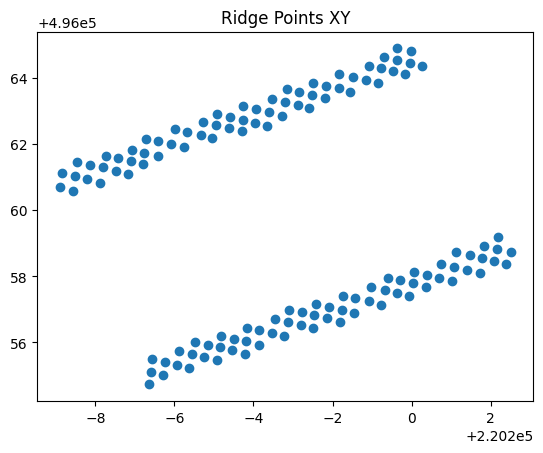

In [99]:
import matplotlib.pyplot as plt
plt.scatter(ridgePoints[:,0], ridgePoints[:,1])
plt.title("Ridge Points XY")
plt.show()

### **5.1 Refined Pose Estimation - Approach 4.1** - <span style="color:red">This is the best one</span>
# <span style="color:yellow">Contour based estimation and refinement + Multi line RANSAC (For multi gable)</span>

In [ ]:
#----------------------------------------------------------------------------------------<Import>--------------------------||
import numpy as np
import open3d as o3d
from shapely.geometry import Polygon
import pyvista as pv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#----------------------------------------------------------------------------------------<Estimate ground>-----------------||
def estimateGroundZ(nearGround, groundPoints, bldPoints, minGroundPts):
    if len(nearGround) >= minGroundPts:
        groundZ = np.mean(nearGround[:, 2])
        groundSource = "local mean"
        print("Option 1 - local mean")

    else:
        groundZ = np.min(groundPoints[:, 2])
        groundSource = "global ground min"
        print("Option 2 - global min")

    # Final safety net
    if not np.isfinite(groundZ):
        print("Invalid groundZ --> Falling back to building min Z")
        groundZ = np.min(bldPoints[:, 2])
        groundSource = "building min Z"
        print("Option 3 - building min")

    print(f"Ground Z used: {groundZ:.3f} ({groundSource})")
    return groundZ, groundSource

#----------------------------------------------------------------------------------------<Extract ridge candidates>--------||
def extractRidgeCandidates(bldPoints, groundZ,basePercentile=90,minRidgePts=30,maxRidgeFrac=0.25):
    bldPointsGrounded = bldPoints.copy()
    bldPointsGrounded[:, 2] -= groundZ

    zVals = bldPointsGrounded[:, 2]
    validMask = zVals > 0
    zVals = zVals[validMask]

    if len(zVals) == 0:
        print("No valid ground points found above")
        return None, None

    #Set threshold percentile
    percentileUsed = basePercentile
    zThresh = np.percentile(zVals, percentileUsed)

    ridgeMask = bldPointsGrounded[:, 2] >= zThresh
    ridgePoints = bldPoints[ridgeMask]

    totalPts = len(bldPoints)
    ridgeCount = len(ridgePoints)

    # Adaptive Adjustment
    if ridgeCount < minRidgePts:
        percentileUsed = max(85, basePercentile - 5)
        zThresh = np.percentile(zVals, percentileUsed)
        ridgeMask = bldPointsGrounded[:, 2] >= zThresh
        ridgePoints = bldPoints[ridgeMask]

    elif ridgeCount > maxRidgeFrac * totalPts:
        percentileUsed = min(95, basePercentile + 5)
        zThresh = np.percentile(zVals, percentileUsed)
        ridgeMask = bldPointsGrounded[:, 2] >= zThresh
        ridgePoints = bldPoints[ridgeMask]

    ridgeCount = len(ridgePoints)

    print("Ridge extraction summary:")
    print(f"  Percentile used : P{percentileUsed}")
    print(f"  Height threshold: {zThresh:.3f}")
    print(f"  Ridge points    : {ridgeCount}/{totalPts}")

    if ridgeCount < minRidgePts:
        print("Few ridge candidates!!")

    return ridgePoints, percentileUsed

In [ ]:
#----------------------------------------------------------------------------------------<Ridge Est. - Multi line RANSAC>--||
def fitMultipleLinesRANSAC(pointsXY,maxIterations=800,distanceThresh=0.3,minInliers=20):
    #Objective is to extract multiple line hypotheses using RANSAC. It returns list of (theta, inlierCount, spanLength).
    N = pointsXY.shape[0]
    lineHypotheses = []

    if N < minInliers:
        return lineHypotheses

    for _ in range(maxIterations):
        idx = np.random.choice(N, 2, replace=False)
        p1, p2 = pointsXY[idx]

        dirVec = p2 - p1
        norm = np.linalg.norm(dirVec)
        if norm == 0:
            continue
        dirVec /= norm

        diffs = pointsXY - p1
        distances = np.abs(diffs[:, 0] * dirVec[1] - diffs[:, 1] * dirVec[0])
        inlierIdx = np.where(distances < distanceThresh)[0]

        if len(inlierIdx) < minInliers:
            continue

        inliers = pointsXY[inlierIdx]

        projections = inliers @ dirVec
        spanLength = projections.max() - projections.min()

        theta = np.arctan2(dirVec[1], dirVec[0])
        theta = theta % np.pi

        lineHypotheses.append((theta, len(inliers), spanLength))

    return lineHypotheses

#----------------------------------------------------------------------------------------<Ridge Direction Estn>------------||
def estimateRidgeDirection(ridgePoints,minPts=30,maxIterations=800,distanceThresh=0.3,angleBinSize=np.deg2rad(5)):
    # Estimate dominant ridge direction using multi line RANSAC voting
    if ridgePoints is None or len(ridgePoints) < minPts:
        print("Not enough ridge points for direction estimation!!!")
        return None, "insufficient_points", 0.0

    pointsXY = ridgePoints[:, :2]

    #Multi line RANSAC
    hypotheses = fitMultipleLinesRANSAC(
        pointsXY,
        maxIterations=maxIterations,
        distanceThresh=distanceThresh,
        minInliers=minPts
    )

    if len(hypotheses) == 0:
        print("No valid line hypotheses found!!!")
        return None, "no_lines", 0.0

    # Direction Voting
    angleBins = {}

    for theta, inlierCount, spanLength in hypotheses:
        binKey = int(theta / angleBinSize)
        score = inlierCount * spanLength

        if binKey not in angleBins:
            angleBins[binKey] = {
                "score": 0.0,
                "angles": []
            }

        angleBins[binKey]["score"] += score
        angleBins[binKey]["angles"].append(theta)

    # Select dominant bin
    bestBin = max(angleBins.items(), key=lambda x: x[1]["score"])
    dominantAngles = bestBin[1]["angles"]
    confidence = bestBin[1]["score"]

    thetaFinal = np.mean(dominantAngles)

    print("Direction estimation using multi-line RANSAC voting")
    print(f"  Hypotheses count : {len(hypotheses)}")
    print(f"  Dominant bin size: {len(dominantAngles)}")

    return thetaFinal, "multi_ransac", confidence

In [ ]:
#----------------------------------------------------------------------------------------<OBB Helper fN>-------------------||
def rotatePointsXY(points, theta):
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

    rotatedXY = points[:, :2] @ R.T
    rotatedPoints = points.copy()
    rotatedPoints[:, :2] = rotatedXY

    return rotatedPoints


def computeAxisAlignedCuboid(bldPoints, groundZ):
    heights = bldPoints[:, 2] - groundZ
    maxHeight = np.max(heights)

    if maxHeight <= 0:
        print("No height --> Z-range fallback!!")
        maxHeight = np.ptp(bldPoints[:, 2])

    # XY bounds
    minXY = np.min(bldPoints[:, :2], axis=0)
    maxXY = np.max(bldPoints[:, :2], axis=0)

    rectCoords = np.array([
        [minXY[0], minXY[1], groundZ],
        [maxXY[0], minXY[1], groundZ],
        [maxXY[0], maxXY[1], groundZ],
        [minXY[0], maxXY[1], groundZ],
        [minXY[0], minXY[1], groundZ]  # closed polygon
    ])

    return rectCoords, maxHeight


def generateCuboidMesh(rectCoords3D, groundZ, height):
    bottom = rectCoords3D
    top = rectCoords3D.copy()
    top[:, 2] = groundZ + height

    vertices = np.vstack([bottom, top])

    faces = []
    numVerts = len(bottom)
    N = numVerts - 1

    faces.append(np.hstack([[numVerts], np.arange(0, numVerts)])) # Bottom face
    faces.append(np.hstack([[numVerts], np.arange(numVerts, 2 * numVerts)])) #Top face
    for i in range(N): #Side faces
        b1, b2 = i, i + 1
        t1, t2 = i + numVerts, i + 1 + numVerts
        faces.append(np.array([4, b1, b2, t2, t1]))

    faces = np.hstack(faces)
    return pv.PolyData(vertices, faces)

In [ ]:
def computeMinAreaRectangleCuboid(bldPoints, groundZ):
    # Fallback cuboid using minimum-area rectangle
    pointsXY = bldPoints[:, :2]
    hull = Polygon(pointsXY).convex_hull
    minRect = hull.minimum_rotated_rectangle

    rectCoords = np.array(minRect.exterior.coords)
    rectCoords3D = np.hstack([
        rectCoords[:, :2],
        np.full((len(rectCoords), 1), groundZ)
    ])

    height = np.max(bldPoints[:, 2] - groundZ)
    return rectCoords3D, height

In [ ]:
fName = "Bldngs__000055"
tileName = "28AN1_16"

bldFile = f"/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/{tileName}/Separated/{fName}.ply"
groundFile = f"/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments/{tileName}/{tileName}_Ground.ply"

radius = 15.0        # Local ground search
minGroundPts = 10    # Min rqd grnd pts

#Ridge extraction parameters
basePercentile = 95 #90      # initial hgt percentile
minRidgePts = 20 #30         # min ridge pts rqd
maxRidgeFrac = 0.25          # max fraction of bldng pts allowed

In [ ]:
bldPC = o3d.io.read_point_cloud(bldFile)
groundPC = o3d.io.read_point_cloud(groundFile)

bldPoints = np.asarray(bldPC.points)
groundPoints = np.asarray(groundPC.points)

bldCentroidXY = np.mean(bldPoints[:, :2], axis=0)
distXY = np.linalg.norm(groundPoints[:, :2] - bldCentroidXY, axis=1)
nearGround = groundPoints[distXY <= radius]

groundZ, groundSource = estimateGroundZ(nearGround,groundPoints,bldPoints,minGroundPts)

ridgePoints, ridgePercentile = extractRidgeCandidates(bldPoints,groundZ,basePercentile=basePercentile,minRidgePts=minRidgePts,maxRidgeFrac=maxRidgeFrac)

Option 1 - local mean
Ground Z used: 6.214 (local mean)
Ridge extraction summary:
  Percentile used : P95
  Height threshold: 8.431
  Ridge points    : 189/3777


In [ ]:
#----------------------------------------------------------------------------------------<Ridge Direction Estimation>------||
theta, directionMethod, confidence = estimateRidgeDirection(ridgePoints,minPts=20,maxIterations=800,distanceThresh=0.3,angleBinSize=np.deg2rad(5))

if theta is not None:
    print(f"Estimated ridge orientation (rad): {theta:.4f}")
    print(f"Method used: {directionMethod}, confidence: {confidence:.3f}")
else:
    print("Ridge based angle est. failed -> Fallback!!!")

#----------------------------------------------------------------------------------------<OBB>-----------------------------||
useRidgeOrientation = theta is not None

if useRidgeOrientation:
    print("Ridge based orientation for cuboid fitting")
    bldPointsRot = rotatePointsXY(bldPoints, -theta)
    rectCoordsRot, height = computeAxisAlignedCuboid(bldPointsRot,groundZ)
    rectCoords3D = rotatePointsXY(rectCoordsRot, theta)

else:
    print("Minimum-area rectangle fallback!!!")
    rectCoords3D, height = computeMinAreaRectangleCuboid(bldPoints,groundZ)

# Generate mesh
cuboid = generateCuboidMesh(rectCoords3D, groundZ, height)
cuboidTri = cuboid.triangulate()

outputFile = f"Outputs/{tileName}_{fName}.ply"
cuboidTri.save(outputFile)

print("Saved LoD1 cuboid:", outputFile)

Direction estimation using multi-line RANSAC voting
  Hypotheses count : 711
  Dominant bin size: 256
Estimated ridge orientation (rad): 3.1020
Method used: multi_ransac, confidence: 346446.034
Ridge based orientation for cuboid fitting
Saved LoD1 cuboid: Outputs/28AN1_16_Bldngs__000055.ply


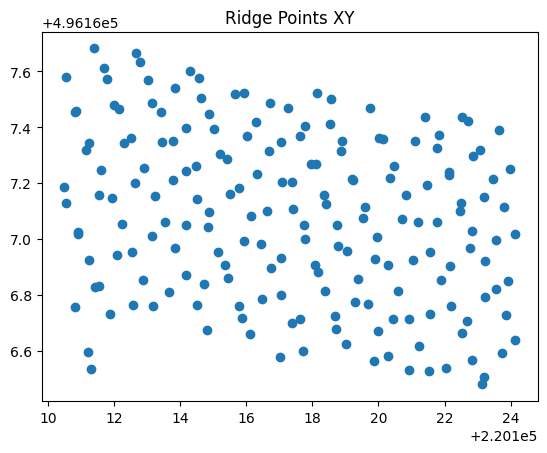

In [9]:
import matplotlib.pyplot as plt
plt.scatter(ridgePoints[:,0], ridgePoints[:,1])
plt.title("Ridge Points XY")
plt.show()

### **5.1.1 Refined Pose Estimation - Approach 4.1** - <span style="color:red">This is the best one</span> - <span style="color:blue">Iterative</span>
# <span style="color:yellow">Contour based estimation and refinement + Multi line RANSAC (For multi gable)</span>
##### <span style="color:red">Execute the above functions</span>

In [10]:
import os
import glob

In [19]:
tileName = "32CN2_11"

In [ ]:
%%time

commonDirectory = "/mnt/d/Krishna/Research/DigitalTwins/LOD1-Archis/DataForExperiments"

bldFolder = f"{commonDirectory}/{tileName}/Separated/"
groundFile = f"{commonDirectory}/{tileName}/{tileName}_Ground.ply"

outputFolder = f"Outputs/{tileName}"
os.makedirs(outputFolder, exist_ok=True)


#----------------------------------------------------------------------------------------<Parameters>----------------------||
# Ground estimation parameters
radius = 15.0        # local ground search
minGroundPts = 10    # min rqd grnd pts

# Ridge extraction parameters
basePercentile = 95 #90      # initial hgt percentile
minRidgePts = 20 #30         # min ridge pts rqd
maxRidgeFrac = 0.25          # max bldng pts allowed

groundPC = o3d.io.read_point_cloud(groundFile)
groundPoints = np.asarray(groundPC.points)

bldFiles = glob.glob(os.path.join(bldFolder, "*.ply"))

for bldFile in bldFiles:
    fName = os.path.basename(bldFile)
    print(f"{fName}\n")

    bldPC = o3d.io.read_point_cloud(bldFile)
    bldPoints = np.asarray(bldPC.points)
    bldCentroidXY = np.mean(bldPoints[:, :2], axis=0)
    distXY = np.linalg.norm(groundPoints[:, :2] - bldCentroidXY, axis=1)
    nearGround = groundPoints[distXY <= radius]

    #----------------------------------------------------------------------------------------------------Ground extraction
    groundZ, groundSource = estimateGroundZ(nearGround,groundPoints,bldPoints,minGroundPts)

    #----------------------------------------------------------------------------------------------------Ridge extraction
    ridgePoints, ridgePercentile = extractRidgeCandidates(bldPoints,groundZ,basePercentile=basePercentile,minRidgePts=minRidgePts,maxRidgeFrac=maxRidgeFrac)

    #----------------------------------------------------------------------------------------------------Ridge Direction Estimation
    theta, directionMethod, confidence = estimateRidgeDirection(ridgePoints,minPts=20,maxIterations=800,distanceThresh=0.3,angleBinSize=np.deg2rad(5))
    
    if theta is not None:
        print(f"Estimated ridge orientation (rad): {theta:.4f}")
        print(f"Method used: {directionMethod}, confidence: {confidence:.3f}")
    else:
        print("Ridge based angle est. failed -> Fallback!!!")

    #----------------------------------------------------------------------------------------------------OBB orientation

    useRidgeOrientation = theta is not None

    if useRidgeOrientation:
        print("Ridge based orientation for cuboid fitting")
        bldPointsRot = rotatePointsXY(bldPoints, -theta)
        rectCoordsRot, height = computeAxisAlignedCuboid(bldPointsRot,groundZ)
        rectCoords3D = rotatePointsXY(rectCoordsRot, theta)
    else:
        print("Minimum-area rectangle fallback!!!")
        rectCoords3D, height = computeMinAreaRectangleCuboid(bldPoints,groundZ)
    
    cuboid = generateCuboidMesh(rectCoords3D, groundZ, height)
    cuboidTri = cuboid.triangulate()

    """FOR NORMAL RECALCULATION || COMMENT THIS IF NOT NEEDED"""
    #cuboidFlat = rebuildMeshWithFlatNormals(cuboidTri)
    
    savePath = f"{outputFolder}/{fName}"
    cuboidTri.save(savePath)
    #cuboidFlat.save(savePath)
    
    print("Saved cuboid:", savePath)
    print("\n"+100*"-"+"\n")

Bldngs__000000.ply

Option 1 - local mean
Ground Z used: 8.628 (local mean)
Ridge extraction summary:
  Percentile used : P95
  Height threshold: 9.229
  Ridge points    : 1789/35736
Direction estimation using multi-line RANSAC voting
  Hypotheses count : 799
  Dominant bin size: 95
Estimated ridge orientation (rad): 0.8237
Method used: multi_ransac, confidence: 504130.394
Ridge based orientation for cuboid fitting
Saved cuboid: Outputs/32CN2_11/Bldngs__000000.ply

----------------------------------------------------------------------------------------------------

Bldngs__000001.ply

Only 3 ground points found ---> fallback!!!
Option 2 - global min
Ground Z used: 4.269 (global ground min)
Ridge extraction summary:
  Percentile used : P95
  Height threshold: 12.333
  Ridge points    : 1785/35688
Direction estimation using multi-line RANSAC voting
  Hypotheses count : 793
  Dominant bin size: 388
Estimated ridge orientation (rad): 1.9601
Method used: multi_ransac, confidence: 8430531.71

In [21]:
print("Done!")

Done!


In [22]:
print("Now work with ReworkMesh.ipynb file")

Now work with ReworkMesh.ipynb file
